In [2]:
# importing libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# reading data
melb_data = pd.read_csv('Data/melb_data.csv')

In [4]:
# examining data
melb_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [6]:
# setting 'Price' column as target for predctions
y = melb_data.Price

#features preparation
features = melb_data.drop(['Price'], axis=1) # remove 'Price' column

# only numerical predicators
X = features.select_dtypes(exclude=['object'])

# divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [9]:
missing_val_count_by_columns = X_train.isnull().sum()
missing_val_count_by_columns

Rooms               0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                49
Landsize            0
BuildingArea     5156
YearBuilt        4307
Lattitude           0
Longtitude          0
Propertycount       0
dtype: int64

In [10]:
# function for comparing different approaches in missing values

def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=10)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [11]:
# approach 1 - drop columns with missing values

def drop_columns(X_train, X_valid):
    # retrieve names of columns with missing values
    cols_with_missing_values = [col for col in X_train.columns if X_train[col].isnull().any()]

    #drop columns from dataset | axis=0 - row, axis=1 - column
    reduced_X_train = X_train.drop(cols_with_missing_values, axis=1)
    reduced_X_valid = X_valid.drop(cols_with_missing_values, axis=1)
    
    return [reduced_X_train, reduced_X_valid]

In [12]:
# scoring of 1st approach

# drop columns with missing values
reduced_X_train, reduced_X_valid = drop_columns(X_train, X_valid)

# predict and evaluating MAE
MAE_drop_column = score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid)
MAE_drop_column

181715.7551528859

In [13]:
# approach 2 - replacing missing values with the mean value along each column

def imputation_dataset(X_train, X_valid):
    # define imputer
    imputer = SimpleImputer()

    # transform datasets
    imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
    imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))
    
    # add columns' names
    imputed_X_train.columns = X_train.columns
    imputed_X_valid.columns = X_valid.columns
    
    return [imputed_X_train, imputed_X_valid]

In [14]:
# scoring of 2nd approach

# imputation missing values
imputed_X_train, imputed_X_valid = imputation_dataset(X_train, X_valid)

# predict and evaluating MAE
MAE_imputation = score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid)
MAE_imputation

178946.13161512028

In [15]:
# approach 3 - replacing missing values with the mean value along each column and mark which values were imputed

# copy of original datasets
X_train_extn = X_train.copy()
X_valid_extn = X_valid.copy()

cols_with_missing_values = [col for col in X_train.columns if X_train[col].isnull().any()]

def imputation_with_mark_dataset(X_train, X_valid):
    # add new column
    for col in cols_with_missing_values:
        X_train_extn[col + '_was_missing'] = X_train_extn[col].isnull()
        X_valid_extn[col + '_was_missing'] = X_valid_extn[col].isnull()
    
    # return imputation function result
    return imputation_dataset(X_train_extn, X_valid_extn)

In [16]:
# scoring of 3rd approach

# imputation missing values with mark
mark_imputed_X_train, mark_imputed_X_valid = imputation_with_mark_dataset(X_train, X_valid)

# predict and evaluating MAE
MAE_mark_imputation = score_dataset(mark_imputed_X_train, mark_imputed_X_valid, y_train, y_valid)
MAE_mark_imputation

177984.30143593522

In [17]:
# create list of MAEs
mae_list = [MAE_drop_column, MAE_imputation, MAE_mark_imputation]

# mae rescaling
# for m in range(0, len(mae_list)):
#     mae_list[m] = mae_list[m] / 10000

Text(0, 0.5, 'Mean Absolute Error')

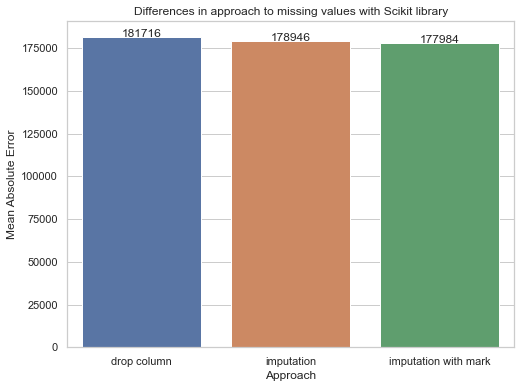

In [18]:
# visualizing differences in approach to missing values

# plot area size
plt.figure(figsize=(8,6))

# style
sns.set_theme(style="whitegrid")

# plot title
plt.title("Differences in approach to missing values with Scikit library")

# define barplot
mae_barplot = sns.barplot(x=['drop column', 'imputation', 'imputation with mark'], y=mae_list)

# set data labels
for p in mae_barplot.patches:
    # get the height of each bar
    height = p.get_height()
    # adding text to each bar
    mae_barplot.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
    y = height+100, # y-coordinate position of data label, padded 100 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center

# axis labels
plt.xlabel("Approach")
plt.ylabel("Mean Absolute Error")